## A/B тестирование(дисперсионный анализ)
В приложении по доставке готовых блюд проведены два теста.
В первом изменена форма фотографий блюд(квадратная и два вида прямоугольных).
Во втором обновлена кнопка заказа.
Необходимо сформулировать и проверить гипотезы с помощью тестов.

In [48]:
#Импортируем библиотеки
import pandas as pd
import scipy.stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import seaborn as sns

In [49]:
#Определим настройки отображения графиков для визуализации
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,8)}
        )


In [50]:
pick_df = pd.read_csv('C:/Users/79256/Github/Data_Analyse/Data/AB_test_food_delivery_1.csv')

In [51]:
pick_df.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


### Первый тест- формат фотографий
Так как необходимо проверить влияние одного фактора - размера фото и имеется три варианта размеров, воспользуемся однофакторным ANOVA

Вначале проверим гомогенность дисперсий при помощи теста Левена. __нулевая гипотеза теста - дисперсии гомогенны__

In [52]:
scipy.stats.levene(
                   pick_df.query('group == "A"').events,
                   pick_df.query('group == "B"').events,
                   pick_df.query('group == "C"').events
                    )
#Получаем p-value больше 0.05, что не позволяет отклонить нулевую гипотезу

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

Теперь проверим нормальность распределения при помощи теста Шапиро-Уилка
Для проверки отбираем сэмплы по 1000 наблюдений
__Нулевая гипотеза теста - распределение нормально.__

In [53]:
scipy.stats.shapiro(
                    pick_df.query('group == "A"') \
                            .events.sample(1000)
                    )
#Получаем p-value больше 0.05, что не позволяет отклонить нулевую гипотезу

ShapiroResult(statistic=0.9977887272834778, pvalue=0.20504577457904816)

In [54]:
scipy.stats.shapiro(
                    pick_df.query('group == "B"') \
                            .events.sample(1000)
                    )
#Получаем p-value больше 0.05, что не позволяет отклонить нулевую гипотезу

ShapiroResult(statistic=0.99814772605896, pvalue=0.35011205077171326)

In [55]:
scipy.stats.shapiro(
                    pick_df.query('group == "C"') \
                            .events.sample(1000)
                    )
#Получаем p-value больше 0.05, что не позволяет отклонить нулевую гипотезу

ShapiroResult(statistic=0.9970842003822327, pvalue=0.06569331139326096)

Проведём тест, однофакторный дисперсионный анализ ANOVA

In [56]:
scipy.stats.f_oneway(
                    pick_df.query('group == "A"').events,
                    pick_df.query('group == "B"').events,
                    pick_df.query('group == "C"').events
                    )
#Получаем p-value меньше 0.05, что позволяет отклонить нулевую гипотезу
#об отсутствии различий

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

При помощи критерия Тьюки определим в какой паре статистически значимые различия(reject)

In [57]:
pairwise_tukeyhsd(pick_df.events, pick_df.group).summary()
#статистически значимые различия оказались между всеми парами
#Столбец meandiff отражает различие в средних между второй и первой группой,
#именно в таком порядке.

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


### Вывод первого теста:
Между всеми группами обнаружены статистически значимые различия.
В прод катим вариант B

### Второй тест- изменение кнопки оформления заказа
Так как необходимо проверить влияние нескольких факторов - формат кнопки и сегмент клиента, воспользуемся многофакторным ANOVA

In [58]:
button_df = pd.read_csv('C:/Users/79256/Github/Data_Analyse/Data/AB_test_food_delivery_2.csv')

In [59]:
button_df.head(3)

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0


In [60]:
button_df.group.value_counts()

control    50000
test       50000
Name: group, dtype: int64

D:\SOFT\DATAANALYST\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

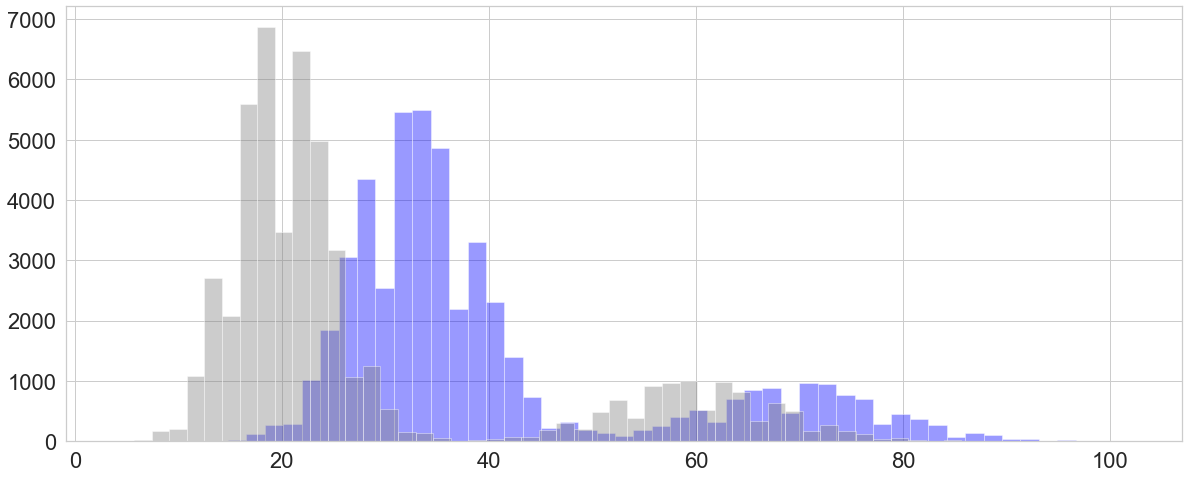

In [61]:
#Строим графики распределения наблюдений по группам
sns.distplot(x=button_df.query('group == "test"').events,kde=False,color='blue')
sns.distplot(x=button_df.query('group == "control"').events,kde=False, color='grey')

In [62]:
#Вычисляем среднее, медиану, стандартное отклонение значений из колонки events
#В разбивке по группам и сегментам
button_df.groupby(['group','segment']) \
            .events \
            .describe()

count       mean       std   min   25%   50%   75%    max
group   segment                                                             
control high     10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

зависимой переменной является 'events', 
независимые- сегмент, группа и взаимодействие этих факторов

In [63]:
#Проводим тест
formula = 'events ~ segment + group + segment:group'
model = ols(formula, button_df).fit()
aov_table = anova_lm(model, typ=2)

In [64]:
aov_table

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377485,0.000000e+00
group,3.837195e+06,1.0,112031.864120,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [65]:
#Добавим колонку с комбинацией факторов для теста Тьюки
button_df['combination'] = button_df['group'] + '/' +  button_df['segment']

In [66]:
button_df.head(3)

,id,group,segment,events,combination
0,83440,test,high,78.0,test/high
1,96723,test,high,71.0,test/high
2,68719,test,high,80.0,test/high


In [67]:
#Проводим тест Тьюки
pairwise_tukeyhsd(button_df.events, button_df.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control/high,control/low,-39.9392,0.001,-40.1073,-39.7711,True
control/high,test/high,9.9677,0.001,9.7551,10.1803,True
control/high,test/low,-26.9449,0.001,-27.113,-26.7768,True
control/low,test/high,49.9069,0.001,49.7388,50.075,True
control/low,test/low,12.9944,0.001,12.888,13.1007,True
test/high,test/low,-36.9126,0.001,-37.0807,-36.7445,True


<AxesSubplot:xlabel='group', ylabel='events'>

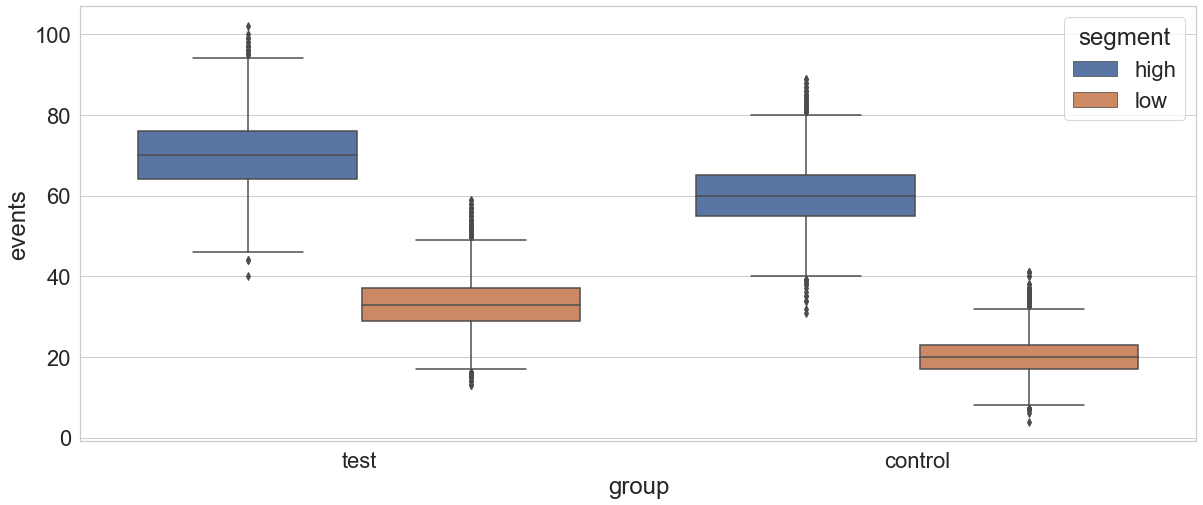

In [72]:
#Визуализируем результаты теста
sns.boxplot(data=button_df, x='group', y='events', hue='segment')

### Вывод второго теста:
Для обоих сегментов показатели статистически значимо увеличились по сравнению с контрольной группой.
Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13, группы сегмента high около 10.
Катим в прод новый дизайн кнопки.